In [4]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy import units as u
import galpy
from galpy.orbit import Orbit
from astropy.coordinates import SkyCoord
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse, Circle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import pygmmis
from sklearn.cluster import KMeans
import json
import pickle

In [5]:
vphi_data = 'df_v_final.fits'

with fits.open(vphi_data) as hdul:
    data = hdul[1].data  
    
    df_v = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

In [6]:
df_v = df_v[np.abs(df_v['Z']) < 2.5]
df_v = df_v.dropna(subset=["v_R", "v_phi", "v_R_uncertainty", "v_phi_uncertainty", "v_Z", "v_Z_uncertainty"])

In [7]:
import pandas as pd
from tqdm import tqdm

def filter_metallicity_bin(df, min_mh, max_mh):
    """
    Filter the dataframe to get stars in the specified metallicity range.
    Args:
    - df: The dataframe containing the data.
    - min_mh: The minimum metallicity value.
    - max_mh: The maximum metallicity value.
    
    Returns:
    - df_bin: The filtered dataframe containing only the stars in the metallicity range.
    """
    df_bin = df[(df['mh_xgboost'] >= min_mh) & (df['mh_xgboost'] < max_mh)]
    return df_bin

df_vmp = filter_metallicity_bin(df_v,-3,-2)
df_imp = filter_metallicity_bin(df_v,-2,-1.6)
df_mp1 = filter_metallicity_bin(df_v,-1.6,-1.3)
df_mp2 = filter_metallicity_bin(df_v,-1.3,-1)

In [5]:
import numpy as np
import pygmmis
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm

def fit_gmm_fixed_components(df_bin, n_components, n_init=50):
    """
    Fits a GMM using Extreme Deconvolution, accounting for measurement errors.

    Args:
    - df_bin: DataFrame for a given metallicity bin.
    - n_components: Number of Gaussian components to use.
    - n_init: Number of initializations to find the best log-likelihood.

    Returns:
    - best_gmm: The best-fit GMM model.
    """
    X = df_bin[['v_R', 'v_phi', 'v_Z']].values
    n = len(X)

    # Construct per-star diagonal covariance matrices
    uncertainties = np.stack([
        df_bin['v_R_uncertainty'].values**2,
        df_bin['v_phi_uncertainty'].values**2,
        df_bin['v_Z_uncertainty'].values**2
    ], axis=1)
    cov_matrices = np.array([np.diag(uncertainty) for uncertainty in uncertainties])

    best_gmm = None
    best_logL = -np.inf

    for _ in tqdm(range(n_init), desc=f"Fitting GMM with {n_components} components"):
        gmm = pygmmis.GMM(K=n_components, D=3)  # GMM in 3D velocity space

        # Initialize using KMeans
        pygmmis.initFromKMeans(gmm, X)

        # Fit GMM using Extreme Deconvolution (XD)
        logL, _ = pygmmis.fit(gmm, X, covar=cov_matrices, w=0.1, tol=1e-6, init_method='kmeans')

        if logL > best_logL:
            best_logL = logL
            best_gmm = gmm

    return best_gmm


In [80]:
def plot_gmm_with_contributions(df_bin, gmm, bin_label, bins=100, x_limits=(-400, 400), y_limits=(-400, 400), 
                                component_colors=None, metallicity_range=""):
    """
    Plots a 2D histogram of v_phi vs v_R and overlays GMM components as 2σ ellipses.
    Also adds a histogram above showing the fractional contribution of each GMM component.
    The metallicity range and label are displayed in the bottom-right corner.

    Args:
    - df_bin: DataFrame containing velocity data.
    - gmm: Fitted GMM model.
    - bin_label: Label for the metallicity bin.
    - bins: Number of bins for 2D histogram.
    - x_limits: Tuple (min, max) for v_R.
    - y_limits: Tuple (min, max) for v_phi.
    - component_colors: List of colors for GMM components (default: pre-defined colors).
    - metallicity_range: String representing the metallicity range (e.g., "-1.6 < [M/H] < -1.3").
    """

    # Default colors (if not provided)
    default_colors = ['blue', 'red', 'aqua', 'gold', 'green', 'purple', 'orange', 'pink']
    if component_colors is None:
        component_colors = default_colors
    elif len(component_colors) < gmm.K:
        raise ValueError(f"Not enough colors provided! Expected {gmm.K}, got {len(component_colors)}")

    # Create figure with 2 subplots: top for component fractions, bottom for 2D histogram
    fig, axes = plt.subplots(2, 1, figsize=(4, 6), gridspec_kw={'height_ratios': [1, 3]}, constrained_layout=True)

    # Drop NaN values
    df_filtered = df_bin.dropna(subset=["v_R", "v_phi"])
    
    # Compute 2D histogram
    H, xedges, yedges = np.histogram2d(
        df_filtered["v_R"], 
        df_filtered["v_phi"], 
        bins=bins, range=[x_limits, y_limits], density=True
    )

    # Normalize the histogram (min-max scaling)
    H_min = np.min(H[H > 0]) if np.any(H > 0) else 1e-5
    H_max = np.max(H) if np.max(H) > 0 else 1
    H_normalized = (H - H_min) / (H_max - H_min)
    H_normalized = np.clip(H_normalized, 0, 1)

    # Bottom subplot: 2D Histogram with GMM ellipses
    ax = axes[1]
    im = ax.pcolormesh(xedges, yedges, H_normalized.T, cmap="Greys", shading='auto')

    # Properly extract and normalize GMM component weights
    total_weight = np.sum(gmm.amp)
    weights = (gmm.amp / total_weight) * 100  # Normalize to percentage contribution

    for i in range(gmm.K):
        mean = gmm.mean[i][:2]  # (v_R, v_phi) mean
        cov = gmm.covar[i][:2, :2]  # Extract 2D covariance

        # Compute eigenvalues & eigenvectors for ellipse
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = eigvals.argsort()[::-1]  # Sort eigenvalues
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]

        # Ellipse properties
        angle = np.arctan2(*eigvecs[:, 0][::-1])  # Rotation angle
        width, height = 2 * np.sqrt(eigvals) * 2  # 2σ scaling

        # Create and add ellipse
        ell = Ellipse(xy=mean, width=width, height=height, angle=np.degrees(angle),
                      edgecolor=component_colors[i], facecolor='none', lw=2, label=f"Component {i+1}")
        ax.add_patch(ell)

    # Set labels
    ax.set_xlabel(r"$v_R$ (km/s)")
    ax.set_ylabel(r"$v_\phi$ (km/s)")
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.grid(False)

    # Add metallicity range and label (bottom-right corner)
    ax.text(x_limits[1] - 50, y_limits[0] + 20, f"{bin_label}\n{metallicity_range}", 
            fontsize=12, color='black', ha='right', va='bottom')

    # Top subplot: Fractional contribution histogram
    ax_frac = axes[0]
    bars = ax_frac.bar(range(1, gmm.K + 1), weights, color=component_colors[:gmm.K], alpha=0.8)

    # Add values on top of each bar (formatted to two significant figures)
    for bar, weight in zip(bars, weights):
        ax_frac.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, 
                     f"{weight:.4g}%", ha='center', fontsize=8, color='black')

    ax_frac.set_xticks(range(1, gmm.K + 1))
    ax_frac.set_xticklabels([f"Comp {i+1}" for i in range(gmm.K)])
    ax_frac.set_ylim(0, max(weights) * 1.2)  # Scale y-axis for better visibility

    # Show plot
    plt.show()


In [47]:
import pickle
import numpy as np
import pandas as pd

def extract_gmm_parameters(gmm, df, label, component_assignments=None):
    """
    Extracts mean, standard deviation, weights, and number of stars from a GMM,
    ensuring the order of components is always:
    - Stationary halo
    - Prograde halo
    - GS/E 1
    - GS/E 2
    - Thick Disc (if applicable)

    Args:
    - gmm: The loaded Gaussian Mixture Model.
    - df: The corresponding DataFrame for the metallicity bin.
    - label: Label for the metallicity bin.
    - component_assignments: A dictionary mapping component names to GMM indices.

    Returns:
    - Formatted string with GMM parameters.
    """
    n_components = gmm.K  # Number of components
    num_stars = len(df)  # Number of stars in the sample

    # Define the fixed component order
    all_component_names = ["Stationary halo", "Prograde halo", "GS/E 1", "GS/E 2", "Thick Disc"]
    component_names = all_component_names[:n_components]  # Use only needed names

    # Extract means and standard deviations
    means = gmm.mean.round(2)  # Shape (n_components, 3) -> (v_R, v_phi, v_Z)
    std_devs = np.sqrt(np.diagonal(gmm.covar, axis1=1, axis2=2)).round(2)  # Shape (n_components, 3)
    
    # Extract weights and convert to percentages
    weights = (gmm.amp / np.sum(gmm.amp) * 100).round(1)

    # Sort components based on user-provided assignments, otherwise use default sorting
    if component_assignments:
        ordered_indices = [component_assignments[name] for name in component_names if name in component_assignments]
    else:
        ordered_indices = np.argsort(means[:, 1])  # Sort by v_phi (column index 1) if no manual assignment

    means = means[ordered_indices]
    std_devs = std_devs[ordered_indices]
    weights = weights[ordered_indices]

    # Create DataFrame for structured output
    df_results = pd.DataFrame({
        "Component": component_names,
        "Weights (%)": weights,
        r"$v_R$": means[:, 0],
        r"$\sigma_R$": std_devs[:, 0],
        r"$v_\phi$": means[:, 1],
        r"$\sigma_\phi$": std_devs[:, 1],
        r"$v_Z$": means[:, 2],
        r"$\sigma_Z$": std_devs[:, 2]
    })

    # Format output
    output = f"\n{label} ({num_stars} stars)\n"
    output += df_results.to_string(index=False, justify="center")

    return output


In [6]:
gmm_vmp = fit_gmm_fixed_components(df_vmp, 2, n_init=50)

Fitting GMM with 2 components: 100%|██████████| 50/50 [06:34<00:00,  7.90s/it]


In [50]:
import pickle

# Save the fitted GMM model to a file
with open("gmm_vmp.pkl", "wb") as f:
    pickle.dump(gmm_vmp, f)


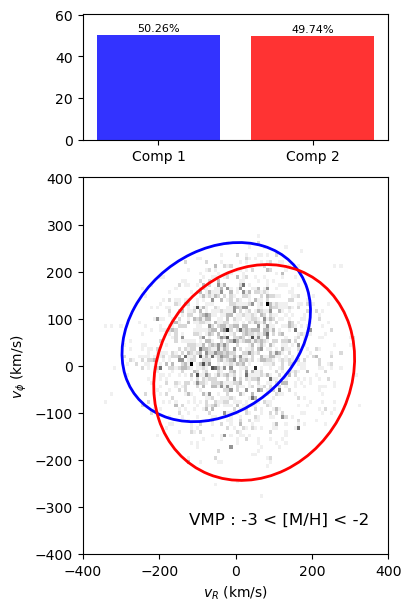

In [81]:
plot_gmm_with_contributions(df_vmp, gmm_vmp, bin_label="VMP : -3 < [M/H] < -2")


In [49]:
component_assignments_vmp = {
    "Stationary halo": 1,
    "Prograde halo": 0
}

output_vmp = extract_gmm_parameters(gmm_vmp, df_vmp, "VMP: −3.0 < [M/H] < −2.0", component_assignments=component_assignments_vmp)
print(output_vmp)



VMP: −3.0 < [M/H] < −2.0 (4768 stars)
   Component     Weights (%)  $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     49.7      48.68    131.49     -14.05      114.52     -4.50     116.52  
  Prograde halo     50.3     -50.65    123.36      71.62       95.06      3.49      92.10  


In [10]:
gmm_imp = fit_gmm_fixed_components(df_imp, 4, n_init=50)

Fitting GMM with 4 components: 100%|██████████| 50/50 [39:42<00:00, 47.66s/it]


In [51]:
with open("gmm_imp.pkl", "wb") as f:
    pickle.dump(gmm_imp, f)


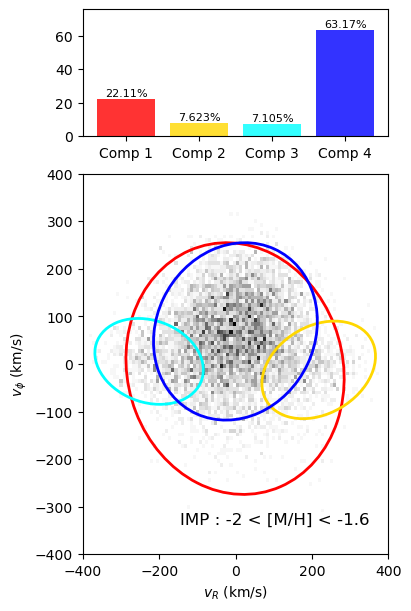

In [82]:
custom_colors = ['red', 'gold','aqua','blue']
plot_gmm_with_contributions(df_imp, gmm_imp, bin_label="IMP : -2 < [M/H] < -1.6", component_colors=custom_colors)


In [56]:
component_assignments_imp = {
    "Stationary halo": 0,  
    "Prograde halo": 3,
    "GS/E 1": 1,
    "GS/E 2": 2
}

output_imp = extract_gmm_parameters(gmm_imp, df_imp, "IMP: −2.0 < [M/H] < −1.6", component_assignments=component_assignments_imp)
print(output_imp)



IMP: −2.0 < [M/H] < −1.6 (12052 stars)
   Component     Weights (%)   $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     22.1       -1.41    142.85      -9.51      132.27     -0.92     124.83  
  Prograde halo     63.2       -0.42    107.25      68.60       93.24     -1.16      72.54  
         GS/E 1      7.6      217.66     74.35     -12.33       51.28     -4.24      89.77  
         GS/E 2      7.1     -226.45     71.01       5.54       45.13      8.39      88.33  


In [45]:
gmm_mp1 = fit_gmm_fixed_components(df_mp1, 5, n_init=50)

Fitting GMM with 5 components: 100%|██████████| 50/50 [41:16<00:00, 49.53s/it]


In [52]:
with open("gmm_mp1.pkl", "wb") as f:
    pickle.dump(gmm_mp1, f)


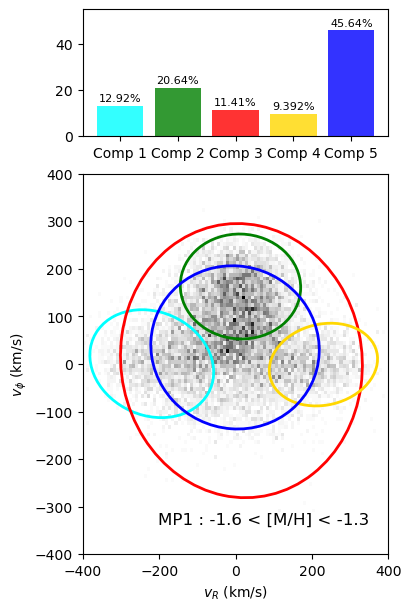

In [78]:
custom_colors = ['aqua','green', 'red','gold','blue']
plot_gmm_with_contributions(df_mp1, gmm_mp1, bin_label="MP1 : -1.6 < [M/H] < -1.3", component_colors=custom_colors)

In [59]:
component_assignments_mp1 = {
    "Stationary halo": 2,  # Assign index based on v_phi
    "Prograde halo": 4,
    "GS/E 1": 0,
    "GS/E 2": 3,
    "Thick Disc": 1
}

output_mp1 = extract_gmm_parameters(gmm_mp1, df_mp1, "MP1: −1.6 < [M/H] < −1.3", component_assignments=component_assignments_mp1)
print(output_mp1)



MP1: −1.6 < [M/H] < −1.3 (19142 stars)
   Component     Weights (%)   $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     11.4       15.29    158.34       7.18      144.07     -2.62     131.67  
  Prograde halo     45.6       -1.48    110.26      34.99       85.78     -0.47      70.40  
         GS/E 1     12.9     -219.49     81.04       0.78       56.72      0.55      90.66  
         GS/E 2      9.4      229.98     70.86      -1.15       43.46      1.28      92.64  
     Thick Disc     20.6       12.78     78.80     163.00       55.14     -2.55      68.50  


In [53]:
gmm_mp2 = fit_gmm_fixed_components(df_mp2, 5, n_init=50)

Fitting GMM with 5 components: 100%|██████████| 50/50 [1:32:34<00:00, 111.09s/it]


In [54]:
with open("gmm_mp2.pkl", "wb") as f:
    pickle.dump(gmm_mp2, f)


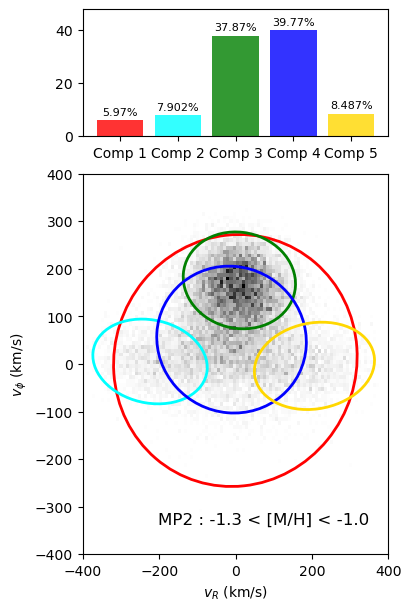

In [79]:
custom_colors = ['red','aqua','green','blue','gold']
plot_gmm_with_contributions(df_mp2, gmm_mp2, bin_label="MP2 : -1.3 < [M/H] < -1.0", component_colors=custom_colors)

In [62]:
component_assignments_mp2 = {
    "Stationary halo": 0,  # Assign index based on v_phi
    "Prograde halo": 2,
    "GS/E 1": 1,
    "GS/E 2": 4,
    "Thick Disc": 2
}

output_mp2 = extract_gmm_parameters(gmm_mp2, df_mp2, "MP2: −1.3 < [M/H] < −1.0", component_assignments=component_assignments_mp2)
print(output_mp2)



MP2: −1.3 < [M/H] < −1.0 (30892 stars)
   Component     Weights (%)   $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo      6.0       -0.59    159.46       7.44      132.42     -3.22     120.96  
  Prograde halo     37.9        9.88     73.51     175.86       50.90      0.77      62.08  
         GS/E 1      7.9     -224.01     74.88       5.40       44.54      2.45      87.24  
         GS/E 2      8.5      206.49     78.63      -3.86       45.90     -2.11      89.78  
     Thick Disc     37.9        9.88     73.51     175.86       50.90      0.77      62.08  


In [8]:
with open("gmm_vmp.pkl", "rb") as f:
    gmm_vmp = pickle.load(f)

with open("gmm_imp.pkl", "rb") as f:
    gmm_imp = pickle.load(f)

with open("gmm_mp1.pkl", "rb") as f:
    gmm_mp1 = pickle.load(f)

with open("gmm_mp2.pkl", "rb") as f:
    gmm_mp2 = pickle.load(f)

# Section for uncertainty analysis

### should be of the order of 0.1 km/s

redo the previous procedure 100 times or so (regenerate the velocities according to the measurement error for each individual star)